O script realiza a análise de sentimentos de avaliações extraídas de um arquivo JSON, garantindo a integridade dos dados ao tratar erros de carregamento e remover duplicatas. As avaliações são organizadas em um DataFrame Pandas, permitindo verificar a distribuição dos sentimentos e identificar padrões nos dados. A análise inclui a contagem e visualização das notas (ratings) para entender a percepção geral dos usuários. Gráficos são gerados para ilustrar a frequência das avaliações e auxiliar na interpretação dos sentimentos. Por fim, exemplos de avaliações positivas e negativas são exibidos para destacar diferenças no tom e no conteúdo dos comentários.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128315 (\N{DOWN-POINTING RED TRIANGLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


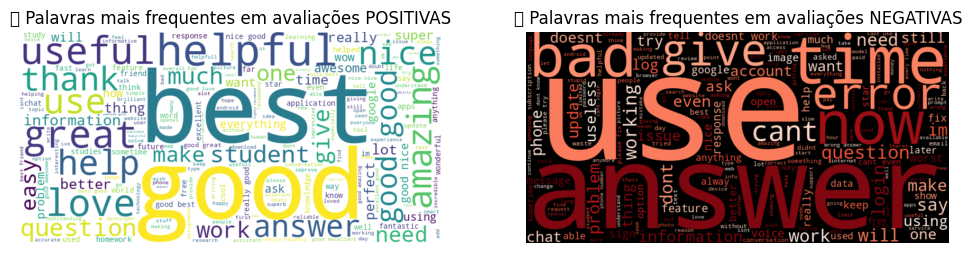

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import json
import re

caminho_json = r"dados.json"

# Carregar dados
with open(caminho_json, "r", encoding="utf-8") as f:
    dados = json.load(f)

df = pd.DataFrame(dados)

stopwords_personalizadas = {"chatgpt", "app", "software", "ai", "bot", "gpt"}
palavras_positivas = {"good", "great", "excellent"}

def limpar_texto(texto, remover_palavras_positivas=False):
    if texto is None:
        return ""

    texto = texto.lower()
    texto = re.sub(r'\bchat\s?gpt\b', '', texto)  # Remover variações de "ChatGPT"
    texto = re.sub(r'\bapp\b', '', texto)  # Remover variações de "App"
    texto = re.sub(r'[^a-z\s]', '', texto)

    palavras = texto.split()  # Quebrar o texto em palavras
    palavras_filtradas = [palavra for palavra in palavras if palavra not in stopwords_personalizadas]
    palavras_relevantes = [palavra for palavra in palavras_filtradas if len(palavra) > 1]  # Remover palavras de 1 caractere

    if remover_palavras_positivas:
        palavras_relevantes = [word for word in palavras_relevantes if word not in palavras_positivas]

    return " ".join(palavras_relevantes)

# Criar coluna 'Sentimento'
def definir_sentimento(nota):
    if nota >= 4:
        return "Positivo"
    elif nota <= 2:
        return "Negativo"
    else:
        return "Neutro"

if 'Ratings' in df.columns:
    df["Sentimento"] = df["Ratings"].apply(definir_sentimento)
else:
    print("⚠️ A coluna 'Ratings' não está presente no DataFrame!")


df["Review_Limpo"] = df.apply(
    lambda row: limpar_texto(row["Review"], remover_palavras_positivas=row["Sentimento"] == "Negativo"), axis=1
)

texto_positivo = " ".join(df[df["Sentimento"] == "Positivo"]["Review_Limpo"].dropna())
texto_negativo = " ".join(df[df["Sentimento"] == "Negativo"]["Review_Limpo"].dropna())

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(texto_positivo)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(texto_negativo)
plt.figure(figsize=(12, 5))

# Nuvem de palavras para avaliações positivas
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("🔹 Palavras mais frequentes em avaliações POSITIVAS")

# Nuvem de palavras para avaliações negativas
if len(texto_negativo) > 0:
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_neg, interpolation="bilinear")
    plt.axis("off")
    plt.title("🔻 Palavras mais frequentes em avaliações NEGATIVAS")
else:
    print("⚠️ O texto das avaliações negativas está vazio! A nuvem de palavras não será gerada.")

plt.show()
